In [1]:
################## imports  ####################################
import urllib.request
import pandas as pd
import json
import os
from tqdm.notebook import tqdm
import networkx as nx
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk
import os
from tqdm.notebook import tqdm
import json
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import RegexpTokenizer
from matplotlib.lines import Line2D


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def get_charactername_from_filename(filename):
    return filename.replace("_*_"," ").replace("-*-","/").replace(".txt","")

dc_unv = "DC"
marvel_unv = "Marvel"
universes = [dc_unv, marvel_unv]

In [3]:

labmit1 = pd.read_table("../Data/labMIT-1.0.txt")

#create a dictionary with key the word and value the happinesss average

labmit1_dictionary = dict(zip(labmit1["word"], labmit1["happiness_average"]))

def calculate_sentiment(tokens_list):
    freq = nltk.FreqDist(w for w in tokens_list if w in labmit1_dictionary.keys())
    freq_count = sum(list(freq.values())) 
    sentiment_count = sum(labmit1_dictionary[w]*freq[w] for w in freq.keys())
    if(freq_count != 0):
        return sentiment_count/freq_count
    else:
        return -1
# tokens= ["love","love","joy", "joy", "love","love","lalalla"]
        
# print(calculate_sentiment(tokens, labmit1_dictionary))



In [4]:
#remove punctuation
tokenizer = RegexpTokenizer(r'\w+')

tokens = dict()

for unv_name in universes:
    folder = "../Data"
    target_folder = os.path.join(folder,unv_name)
    for filename in tqdm(os.listdir(target_folder)):
        fn = os.path.join(target_folder, filename)
        # checking if it is a file
        if os.path.isfile(fn):
            f = open(fn, "r")
            html_text = f.read()
            f.close()
            text = BeautifulSoup(html_text, 'html.parser').get_text()
            #remove everything before the json starts
            text = text[text.find("{"):]
            #remove everythong after the json finishes
            text = text.rsplit("}",1)[0]
            text += "}"
            try:
                jsontext = json.loads(text)
            except:
                tokens[get_charactername_from_filename(filename)] = tokenizer.tokenize(str(text))
                continue
                
            pages = jsontext["query"]["pages"]
            for key in jsontext["query"]["pages"]:
                try:
                    text = pages[key]["revisions"]
                except:
                    continue
                tokens[get_charactername_from_filename(filename)] = tokenizer.tokenize(str(text).lower())

  0%|          | 0/518 [00:00<?, ?it/s]

/home/lefteris/anaconda3/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/1784 [00:00<?, ?it/s]

In [5]:
sentiment_per_character = dict(zip(tokens.keys(), map(calculate_sentiment,tokens.values())))

# for x in sentiment_per_character:
#     if sentiment_per_character[x] == -1:
#         sentiment_per_character.pop(x)


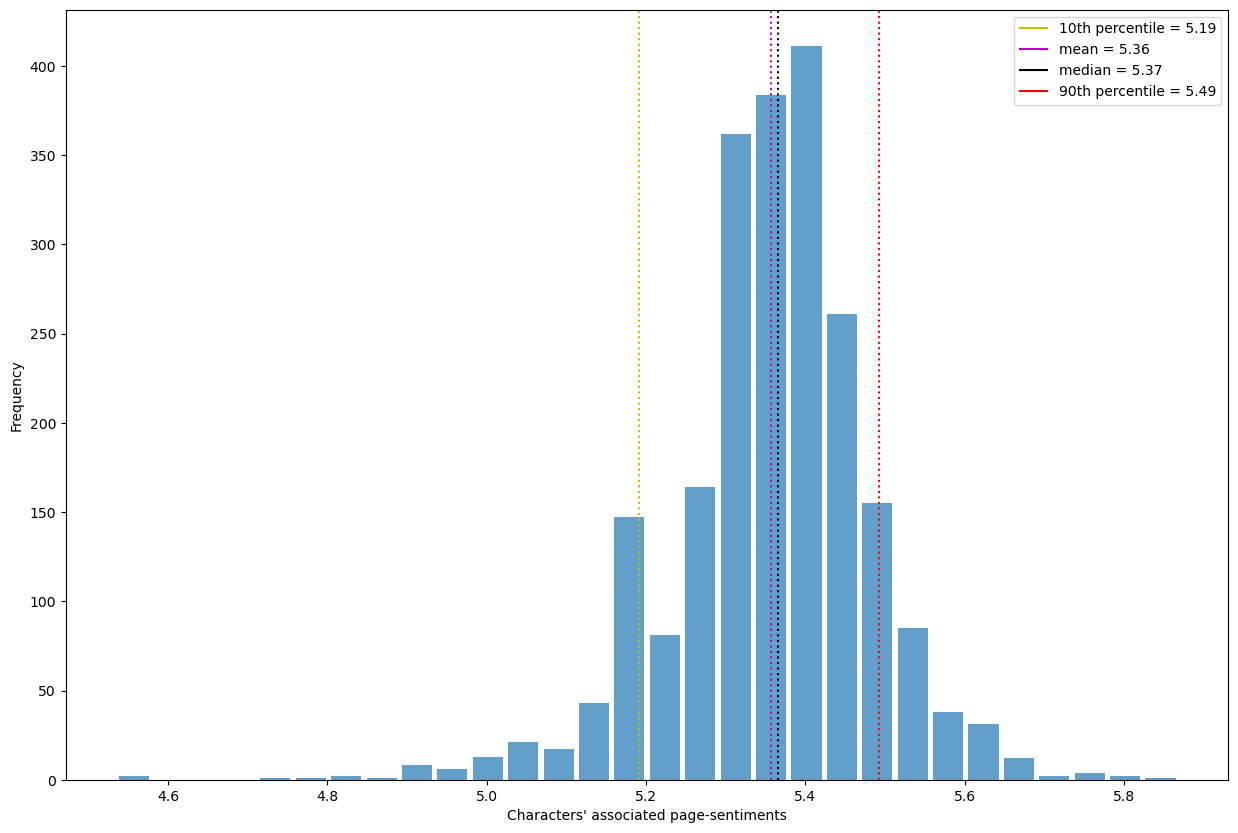

In [6]:

def plot_sentiment(dictionary):
    fig, ax = plt.subplots(figsize = (15,10))
    
    num_of_bins = 30
    counts , edges = np.histogram(list(dictionary.values()),bins=num_of_bins)
    
    max_count = np.max(counts)
    spc = list(dictionary.values())
    plt.hist(spc, bins = num_of_bins, alpha=0.7, rwidth=0.85)

    # Calculate percentiles
    percentile_10, median, mean, percentile_90 = np.percentile(spc,10),np.percentile(spc,50),np.mean(spc), np.percentile(spc,90)

    # [quantile, opacity, length]
    quants = [[percentile_10, "y"], [mean, "m"], [median, "k"],  [percentile_90, "r"]]

    # Plot the lines with a loop
    for i in quants:
        ax.axvline(i[0], color=i[1], linestyle = ":")

#     ax.text(percentile_10-.05, 0.25* max_count, f"10th = {percentile_10:.2f}", size = 10, alpha = 0.8)
#     ax.text(median-.03, 0.75* max_count, "median", size = 11, alpha = 0.85)
#     ax.text(mean, 0.5* max_count, "mean", size = 12, alpha = 1)
#     ax.text(percentile_90, 0.9* max_count, "90th", size = 11, alpha = 0.85)

    legends = [Line2D([0], [0], marker=None, color=quants[0][1], label= f"10th percentile = {quants[0][0]:.2f}"),
               Line2D([0], [0], marker=None, color=quants[1][1], label= f"mean = {quants[1][0]:.2f}"),
               Line2D([0], [0], marker=None, color=quants[2][1], label= f"median = {quants[2][0]:.2f}"),
               Line2D([0], [0], marker=None, color=quants[3][1], label= f"90th percentile = {quants[3][0]:.2f}")]

    ax.set_xlabel("Characters' associated page-sentiments")
    ax.set_ylabel("Frequency")
    
    
    plt.legend(handles = legends, loc=1, fontsize = 10)
    plt.show()
    return mean

average_of_all = plot_sentiment(sentiment_per_character)


In [7]:
sorted_sentiment_per_character = dict(sorted(sentiment_per_character.items(), key=lambda item: item[1], reverse=True))

print("5 happiest:")
i = 0
for char in sorted_sentiment_per_character:
    if i >= 5:
        break
    print(f"{char}: {sorted_sentiment_per_character[char]}")
    i+=1

sorted_sentiment_per_character = dict(sorted(sentiment_per_character.items(), key=lambda item: item[1]))
print("5 saddest:")
i = 0
for char in sorted_sentiment_per_character:
    if i >= 5:
        break
    print(f"{char}: {sorted_sentiment_per_character[char]}")
    i+=1

5 happiest:
Lifeform: 5.868
Free Spirit: 5.7870833333333325
Super Rabbit: 5.782000000000001
Von Bach: 5.766666666666667
Fancy Dan: 5.766666666666667
5 saddest:
Voice: 4.535
Lodestone: 4.535
Stinger: 4.756666666666667
Shiva: 4.796
Albert Cleary: 4.8325000000000005


# Good Bad
* Start by plotting the distribution of sentiment for the pages of good and bad characters separately.
* Now calculate the mean, median, 10th percentile, and 90 percentile sentiment value for each group and indicate those values on the corresponding histograms.
* Comment on these distributions and how they relate to the overall sentiment distribution you calculated in Exercise 1 above.
* Use the "label shuffling technique" that I illustrated in Week 5, exercise 7 to determine whether or not
    the bad guy pages tend to have lower sentiment than a similarly sized group of randomly chosen character pages
    the good guy pages tend to have higher sentiment than a similarly sized group of randomly chosen character pages
* Note: In this assignment I have deliberately chosen to be a little bit less detailed and precise than usual. That's part of the assignment - I want you to practice thinking independently about the interpretation. But don't worry, you can always ask the TAs for help 😀

In [8]:
good_bad = pd.read_table("../Data/good_bad.txt", delimiter=",")

#create a dictionary with key the CharacterName and value = 10 if good, 1 if bad, 0 if neutral
char_mapping = {"good":10, "bad":1, "neutral":0}
good_bad_dictionary = dict(zip(good_bad["CharacterName"], good_bad["good"]*10+good_bad["bad"]))

In [9]:
sentiment_per_good_character = {characterName: sentiment for characterName, sentiment 
                                in sentiment_per_character.items() 
                                if good_bad_dictionary[characterName] == char_mapping["good"]}

sentiment_per_bad_character = {characterName: sentiment for characterName, sentiment 
                                in sentiment_per_character.items() 
                                if good_bad_dictionary[characterName] == char_mapping["bad"]}

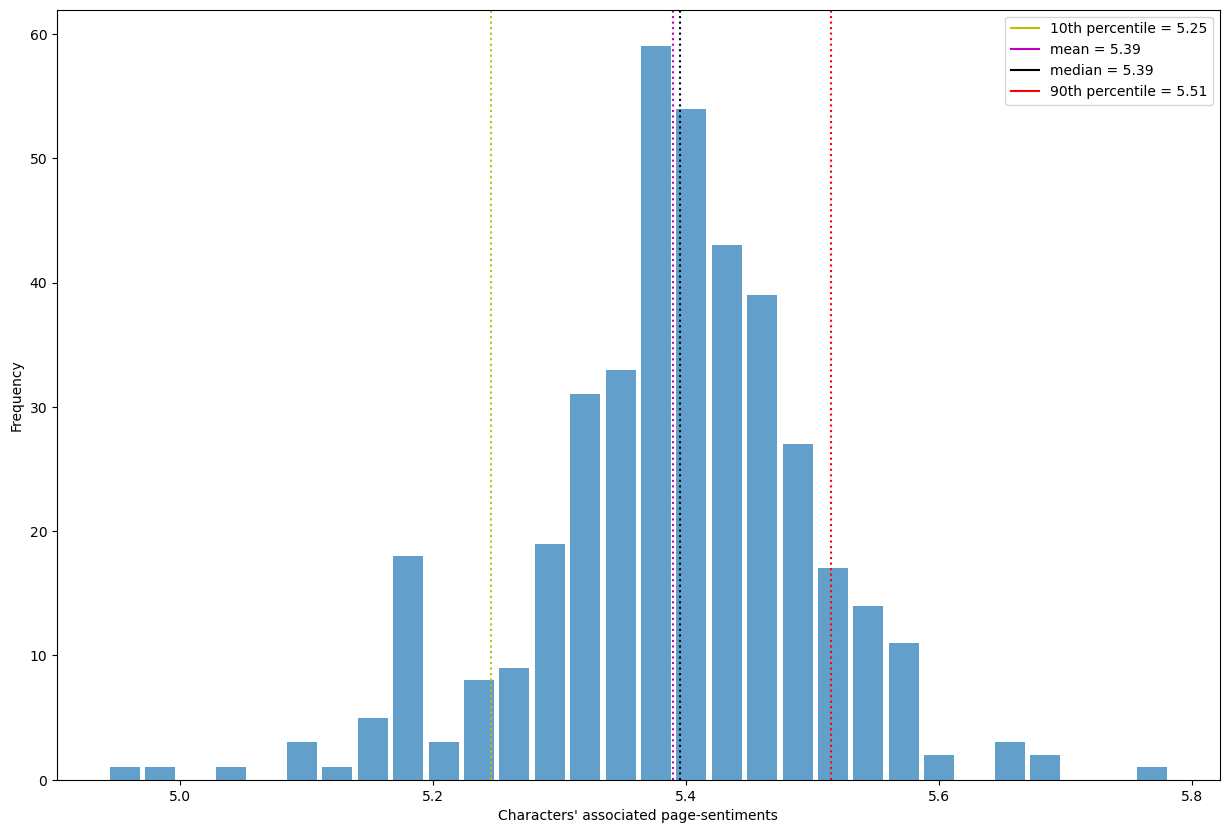

In [10]:
average_of_good = plot_sentiment(sentiment_per_good_character)

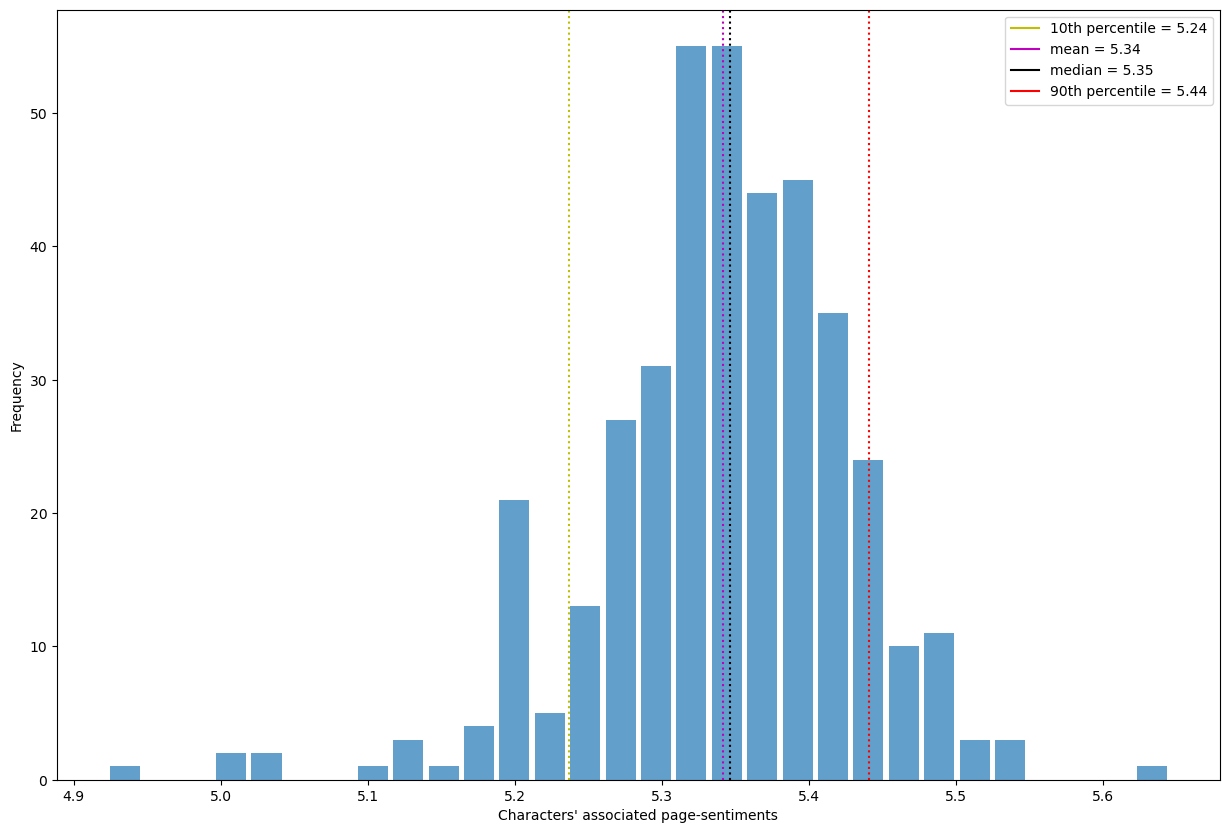

In [11]:
average_of_bad = plot_sentiment(sentiment_per_bad_character)

In [12]:
print(f"Average sentiment of all characters: {average_of_all:.2f}")
print(f"Average sentiment of good characters: {average_of_good:.2f}")
print(f"Average sentiment of bad characters: {average_of_bad:.2f}")

Average sentiment of all characters: 5.36
Average sentiment of good characters: 5.39
Average sentiment of bad characters: 5.34
